# Support Vector Machine II: The Non-Linear Case through the Kernel Trick

In the previous lesson, we saw how **Support Vector Machine (SVM)** find the hyperplane that maximizes the margin between classes. We also discussed the need to **soften these margins** when classes are not perfectly separable, which we addressed by introducing a **regularization term** into the cost function:

$$
\min \frac{1}{2} \|w\|^2 \quad \text{subject to } y_i \cdot \left( \sum_{j} w_j \cdot x_{ij} + b \right) \geq 1
$$

This framework, however, leads only to **linear decision boundaries** — straight lines in two dimensions, or flat hyperplanes in higher dimensions.

But what if the classes are distributed in a **non-linear** way?

No problemo, amigo! SVM can handle such cases using **kernels** and a clever idea known as the **kernel trick**. This capability is one of the main reasons why SVM remain a popular and powerful tool among machine learning practitioners.

We are going to cover all this in this lesson. By the end of it, you should understand:

- The challenge of classifying non-linearly separable data.
- The concept of the **kernel trick** and how it works.
- How the kernel trick enables SVM to handle non-linear problems.
- How to implement non-linear SVM using `scikit-learn`.


## 1. Making data separable by going to higher dimensions

Let us create the following synthetic dataset that is clearly non-linear.

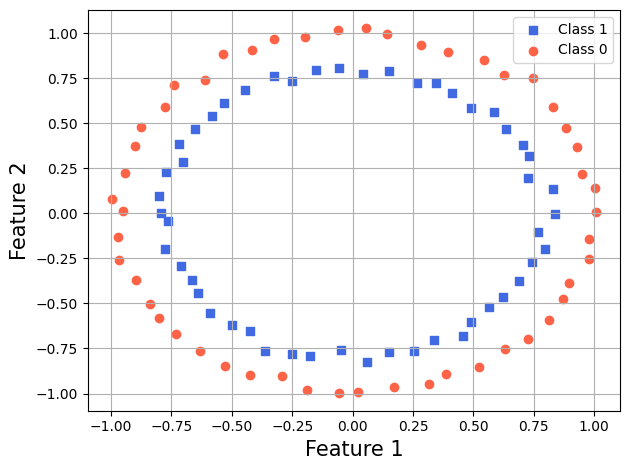

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

X, y = make_circles(noise=0.02, random_state=1234)


np.random.seed(1)
plt.scatter(X[y == 1, 0],X[y == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
plt.tight_layout()
plt.grid("on")
plt.show()

Since these classes are distributed in a non-linear way, if we apply `LinearSVC` as we did in our previous lesson, we will end up with a decision boundary that fails to separate them correctly.

In [2]:
from sklearn.svm import LinearSVC

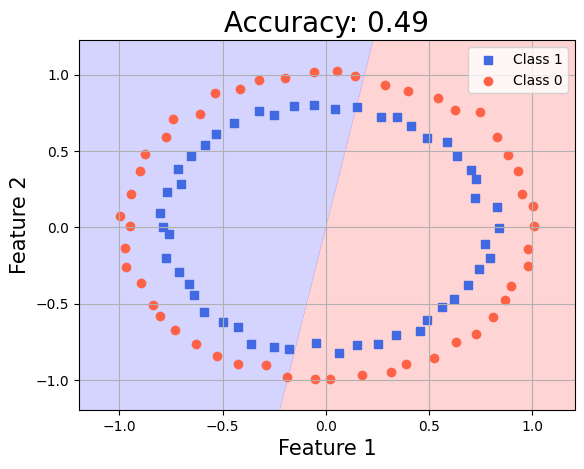

In [3]:
clf = LinearSVC() # Define object
clf.fit(X,y) # Fit
acc = clf.score(X,y) # Calculate accuracy in this case

# Plot decision boundaries

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid).reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=[Z .min(), 0, Z .max()], colors=['#FFAAAA','#AAAAFF'], alpha=0.5)
plt.scatter(X[y == 1, 0],X[y == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='tomato', marker='o',label='Class 0')
plt.title(f"Accuracy: {acc}", size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
plt.grid("on")
plt.show()

However, as we saw in the previous lab with polynomial regression, we can **augment the feature space** by adding non-linear combinations of the original features. This allows us to apply linear models — like SVM — in a transformed space where the data may become linearly separable.

For example, in our 2D toy dataset, we can introduce a new feature:

$$
\vec{x} \equiv (x_1,x_2) \mapsto \left(x_1,x_2, x_{1}^2 + x_{2}^2 \right)
$$

Let's plot our data in this augmented space:

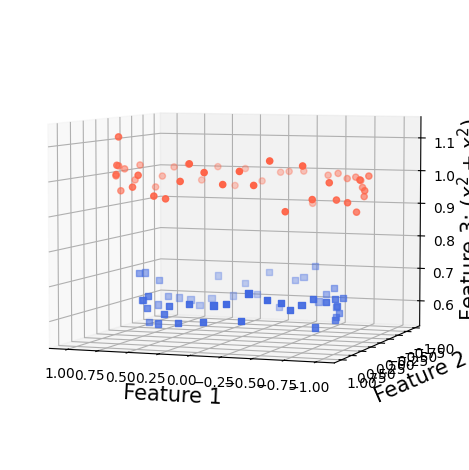

In [4]:
new_feature = (X**2).sum(axis=1)
X_augment = np.column_stack((X, new_feature))

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(X_augment[y == 1][:, 0], X_augment[y == 1][:, 1], X_augment[y == 1][:,2], c='royalblue',  label='Class 1',  marker='s')
ax.scatter(X_augment[y == 0][:, 0], X_augment[y == 0][:, 1], X_augment[y == 0][:,2], c='tomato',   label='Class 0',  marker='o')
ax.view_init(elev=5, azim=110)
ax.set_xlabel('Feature 1', size=15)
ax.set_ylabel('Feature 2', size=15)
ax.set_zlabel('Feature 3: ' + r'$(x_1^2 + x_2^2$)', size=15)
plt.tight_layout()

As you can see, this transformation has mapped each point to a higher-dimensional space and now our classes seem to be separable!

Now SVM should be able to generate a well-behaved decision boundary. Let’s test it!

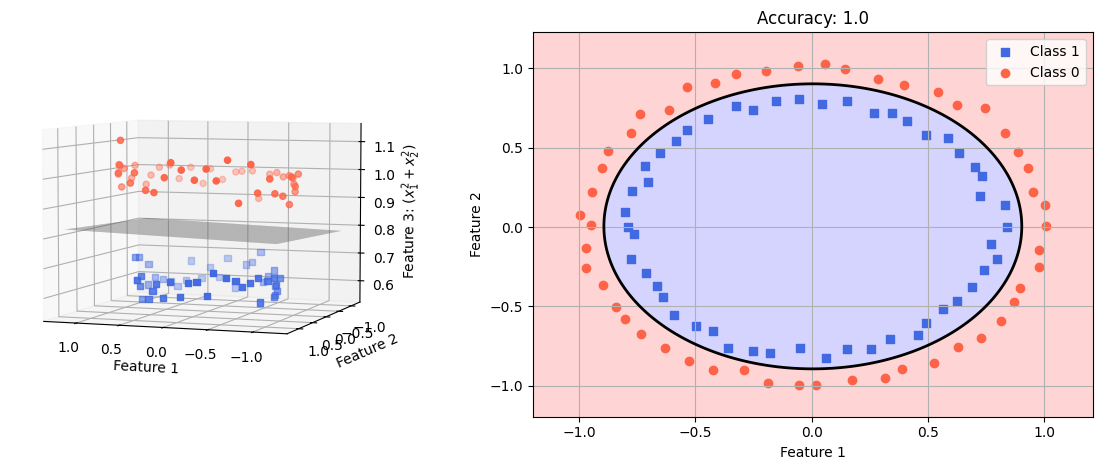

In [5]:
clf = LinearSVC() # Define object
clf.fit(X_augment, y) # Fit
acc = clf.score(X_augment, y) # Calculate accuracy in this case

# Decision Boundary
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
zz = xx**2 + yy**2
grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

# Compute decision boundary plane: w1*x + w2*y + w3*z + b = 0 --> solve for z
# => z = -(w1*x + w2*y + b)/w3
zz_boundary = -(clf.coef_[0,0] * xx + clf.coef_[0,1] * yy + clf.intercept_) / clf.coef_[0,2]
fig = plt.figure(figsize=plt.figaspect(0.4))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot_surface(xx, yy, zz_boundary, alpha=0.5, color='gray', edgecolor='none')

ax1.scatter(X_augment[y == 1][:, 0], X_augment[y == 1][:, 1], X_augment[y == 1][:,2], c='royalblue',  label='Class 1',  marker='s')
ax1.scatter(X_augment[y == 0][:, 0], X_augment[y == 0][:, 1], X_augment[y == 0][:,2], c='tomato',   label='Class 0',  marker='o')
ax1.view_init(elev=5, azim=110)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3: ' + r'$(x_1^2 + x_2^2$)')

Z = clf.decision_function(grid).reshape(xx.shape)

ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(xx, yy, Z, levels=[Z .min(), 0, Z .max()], colors=['#FFAAAA','#AAAAFF'], alpha=0.5)
ax2.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
ax2.scatter(X[y == 1, 0],X[y == 1, 1], c='royalblue', marker='s', label='Class 1')
ax2.scatter(X[y == 0, 0], X[y == 0, 1], c='tomato', marker='o',label='Class 0')
ax2.set_title(f"Accuracy: {acc}")
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend(loc='best')
ax2.grid("on")

plt.tight_layout()

So we can see that by augmenting our feature space, we gain more flexibility to separate the classes.

In general, we can always define a transformation:

$$
\vec{x} \mapsto \phi(\vec{x})
$$

where $\phi(x)$ maps the original input into a new, typically higher-dimensional, feature space.

In this transformed space, the margins of the SVM take the form:

$$
\sum_{j}\phi(\vec{x})_j \cdot w_j + b = \pm 1
$$

For example, we could choose $\phi(\vec{x})$ to be a **polynomial expansion** of the original features. However,  this can significantly increase the dimensionality of our feature space, which comes with two main problems:

- It increases the risk of **overfitting**, especially if we don’t have enough data.
- It can be **computationally inefficient** to explicitly map low-dimensional data into very high-dimensional spaces.

These challenges motivate the use of an elegant solution: the **kernel trick**.

## 2. Dual Formulation of SVM

There is a way to transform our original feature space $x_i$ into a higher-dimensional feature space $\phi(x_i)$, while still keeping the computation efficient.

But to get there, we need to (unfortunately) deal with a bit of math.

---

If you remember from the previous lesson, we started from the following optimization problem:

\begin{align}
& \min \; \|w\|^2 + C \cdot \sum_i \xi_i \\
& \text{subject to } \quad y_i \cdot \left(\sum_{j} w_j \cdot x_{ij} + b\right) \geq 1 - \xi_i, \quad \xi_i \geq 0
\end{align}

We can incorporate the constraints — the “subject to” parts — into the optimization using **Lagrange multipliers**. A Lagrange multiplier is a parameter that weights each constraint and becomes a tunable part of the optimization itself:

$$
\min \; \|w\|^2 + C \cdot \sum_i \xi_i 
- \sum_i \alpha_i \left[y_i \cdot \left(\sum_{j} w_j \cdot x_{ij} + b\right) - (1 - \xi_i)\right] 
- \sum_i \mu_i \cdot \xi_i
$$
where $\alpha_i \geq 0$ and $\mu_i \geq 0$ are the so-called Lagrange multipliers.




---

Minimizing this expression with respect to $w$ and $b$, and solving the resulting system of equations, leads to the **dual formulation** of the SVM optimization problem:

\begin{align}
& \min \; \frac{1}{2} \sum_{i, i'} \alpha_i \alpha_{i'} y_i y_{i'} (\vec{x}_i \cdot \vec{x}_{i'}) - \sum_i \alpha_i \\
& \text{subject to } \quad 0 \leq \alpha_i \leq C, \quad \sum_i \alpha_i y_i = 0
\end{align}


From this dual problem, we can also express the optimal weight vector as a weighted combination of training points:


$$\vec{w} = \sum_i \alpha_i y_i \vec{x}_i$$


So any hyperplane here can be written as:


$$\sum_i \alpha_i y_i (\vec{x}_i \cdot \vec{x}') + b = \text{constant}$$

---

### Why is this important?

1. **Only support vectors matter**: The multipliers $\alpha_i$ are nonzero only for a small number of training points — the *support vectors*. This confirms what we already knew: the margins are determined only by points near the boundary.

2. **Everything depends on dot products**: The decision boundary, as it is an hyperplane, will depend on the **dot product** $\vec{x}_i \cdot \vec{x'}$. This product does not care about the number of features, only that it is computable.  **This is the foundation of the kernel trick!**


## 3. Kernel Trick

What happens if, instead of using the original features, our decision boundary is based on the **transformed** points through a feature map $\phi$? Then it takes the form:

$$
\sum_i \alpha_i y_i  (\vec{\phi}(x_i) \cdot  \vec{\phi}(x)) + b
$$

Again, this only depends on the **dot product** between the transformed points: $ \vec{\phi}(x_i) \cdot  \vec{\phi}(x)$. 

This is key — in the dual formulation, the classifier depends **only** on dot products between transformed points.  If we define a **kernel function**:

$$
K(x, x') = \vec{\phi}(x) \cdot \vec{\phi}(x')
$$

We will not need to know the explicit form of $\phi$ to generate predictions--we just need to be able to calculate the kernel!

----

For example, assume we have 2 features only. Then:

$$K(x, x') = \left( 1 + \sum_{j=1}^2 x_j x'_j\right)^2 = 1 + 2x_1x'_1 + 2x_2x'_2 +  2(x_1 x'_1x_2 x'_2) + (x_1 x'_1)^2 + (x_2 x'_2)^2$$

But this is exactly as if we had transformed the data 

$$x \rightarrow \phi(x) = (1, \sqrt{2}x_1, \sqrt{2}x_2, \sqrt{2}x_1x_2, x_1^2, x_2^2)$$

By computing a value directly from the original features with the kernel function, it is as if we had first transformed the data into a higher-dimensional space — but we never actually need to perform that transformation!

### Kernel choices
Common kernel choices include:

\begin{aligned}
K(x, x') &= \sum_{j} x_j \cdot x'_j && \text{Linear} \\
K(x, x') &= \left( \gamma \cdot \sum_{j} x_j \cdot x'_j + \kappa \right)^d && \text{$d$th-degree Polynomial} \\
K(x, x') &= \exp\left(-\gamma \cdot \sum_{j} (x_j - x'_j)^2 \right) && \text{Radial Basis Function (RBF)} \\
K(x, x') &= \tanh\left( \gamma \cdot \sum_{j} x_j \cdot x'_j + \kappa \right) && \text{Sigmoid}
\end{aligned}


What kernel to use?

- Start with linear kernel as baseline (fast, interpretable).
- If performance is lacking, try RBF (flexible, general-purpose).
- Use polynomial when you have a reason to believe feature interactions matter.
- Use custom kernels if you can encode domain-specific similarity.

Now you are ready to start applying **kernelized SVMs** to nonlinear classification problems (and regression — coming in the next lab!).


## 4. Implementation in `scikit-learn`

The kernelized SVM is implemented in `scikit-learn` through the class `SVC`, located in the `svm` module.

👉 Please take a moment to review its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

The main hyperparameters — typically tuned during training — are:

- `C`: The regularization parameter. This is the same parameter as in `LinearSVC`.
- `kernel`: Specifies the type of kernel to use. Built-in options include `'linear'`, `'poly'`, `'rbf'`, `'sigmoid'`, and also custom kernel functions.
- `gamma`: The $\gamma$ term in kernel functions, which controls the influence of individual training examples. Relevant for RBF, polynomial, and sigmoid kernels.
- `coef0`: The $\kappa$ term used in polynomial and sigmoid kernels, acting as an independent term.

---

Let’s now explore how this implementation works in practice!

To do so, we will use the **XOR problem** — a classic example that illustrates the limitations of linear models and the power of kernelized classifiers.

The XOR function outputs `1` if the two binary inputs are different, and `0` otherwise. Here's how the data looks:

- (0, 0) → 0  
- (0, 1) → 1  
- (1, 0) → 1  
- (1, 1) → 0

This dataset is **not linearly separable**, but SVM with nonlinear kernels can handle it effectively. Let’s see this in action!

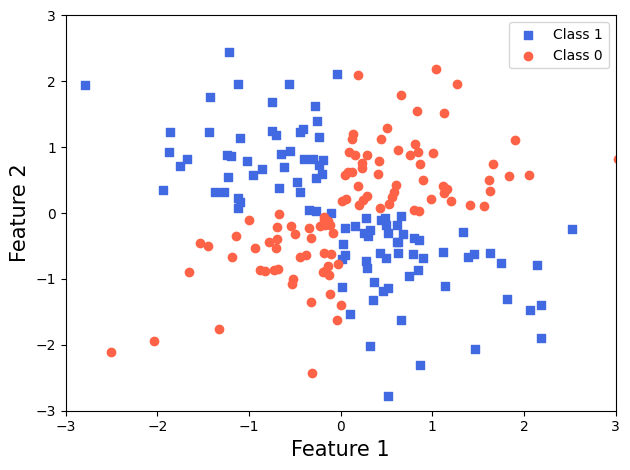

In [6]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0],X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')

plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Let's start with a linear kernel:

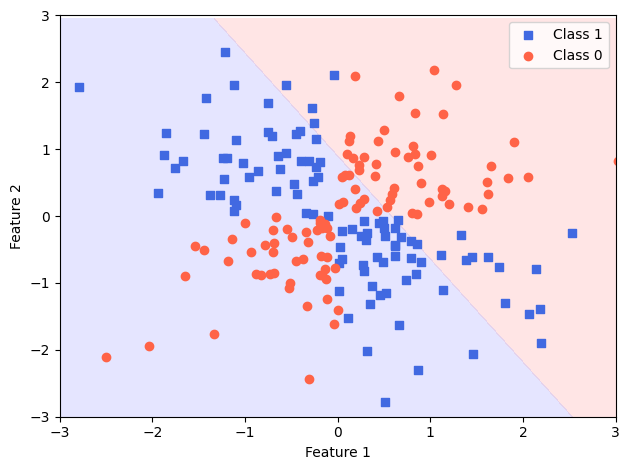

In [7]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', random_state=1, gamma=0.2, C=1)
clf.fit(X_xor, y_xor)

x_min, x_max = X_xor[:,0].min()-0.5, X_xor[:,0].max()+0.5
y_min, y_max = X_xor[:,1].min()-0.5, X_xor[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z,  levels=[Z .min(), 0, Z .max()], colors=['#FFAAAA','#AAAAFF'], alpha=0.3)

plt.scatter(X_xor[y_xor == 1, 0],X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Obviously, using a **linear kernel** gives you a linear decision boundary — which is **not effective** in the XOR case, since the data is not linearly separable.

But what if we try a **nonlinear kernel**?

Let’s now try with a **Radial Basis Function (RBF) kernel**, one of the most popular choices. 

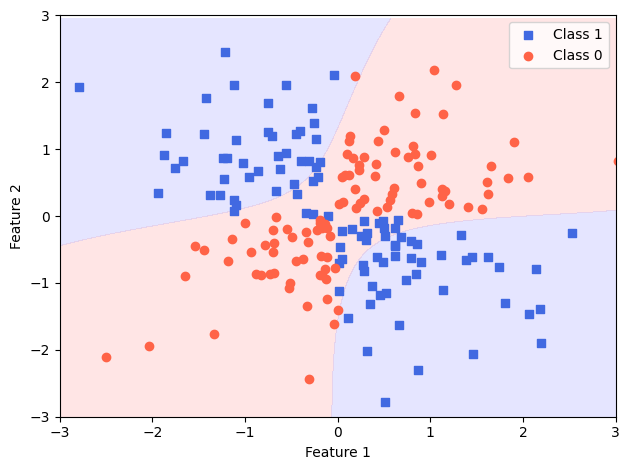

In [8]:
clf = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1)
clf.fit(X_xor, y_xor)

x_min, x_max = X_xor[:,0].min()-0.5, X_xor[:,0].max()+0.5
y_min, y_max = X_xor[:,1].min()-0.5, X_xor[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z,  levels=[Z .min(), 0, Z .max()], colors=['#FFAAAA','#AAAAFF'], alpha=0.3)

plt.scatter(X_xor[y_xor == 1, 0],X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

You can now see how this kernel can effectively handle what is, in principle, a very challenging classification problem.

**Spectacular, isn't it?**

## 5. Summary

- When data is **not linearly separable**, we can map it to a higher-dimensional space via a transformation $\phi(x)$, making it linearly separable.
- SVMs rely only on **dot products** between data points.
- The **kernel trick** allows us to compute dot products in high-dimensional spaces without explicitly transforming the data.
- `SVC` is the `scikit-learn` implementation for kernelized SVMs, with key hyperparameters: `C`, `kernel`, `gamma`, and `coef0`.

## 6. 📝 Exercises

### 6.1 SVM Classification of Orthopaedic Patients (Binary Case)

In this exercise, you will use **Support Vector Machines (SVMs)** to classify orthopaedic patients as either **normal** or **abnormal**, based on six biomechanical features.

This is a real-world data from the UCI Machine Learning Repository — the Vertebral Column dataset — which I import it here for your convenience:

The following dataset can be found in the UCI repository and contains values for six biomechanical features used to classify orthopaedic patients into 3 classes (normal, disk hernia or spondilolysthesis) or 2 classes (normal or abnormal).

In [9]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
    
# fetch dataset 
vertebral_column = fetch_ucirepo(id=212) 
  
# data (as pandas dataframes) 
X = vertebral_column.data.features 
y = vertebral_column.data.targets 

# Normal cases as negative, rest positive
y = (y != "Normal").astype(int).to_numpy().flatten()
X = X.to_numpy()

/home/javi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Your task is to train, tune, and evaluate an SVM classifier on this dataset.

For this, you should:

1. Split the dataset into training and test set, setting 20% for testing.  
2. Find the model with the best combination of hyperparameters. You should try different kernels and regularization coefficient values \( C \).  
3. Using this best model, report the test accuracy and confusion matrix.  
4. Reflect on how the behaviour of the performance varies with the different combinations of hyperparameters.

**IMPORTANT**: I omitted very important details you should consider along the way! Think of the kind of dataset you are working with, the needs of this type of algorithm (SVM), and the fundamentals about how to tune machine learning models properly.

In [10]:
#YOUR CODE